--- 1. Load Data & Preprocessing ---
Loading data from: C:\Users\mason\AVP\BTCUSDrec.csv
Raw data loaded. Shape: (15177, 9)
Selected the last 15000 rows for backtesting.
Data prepared for feature engineering. Shape: (15000, 7)

--- 2. Feature Engineering ---
Starting comprehensive feature calculation...
Feature calculation finished. Returning 15000 rows. Took 0.14s
Feature calculation completed in 0.15 seconds.
Proceeding with 56 features found out of 56 selected.

--- 3. Define Target Variable ---
Defining target variable: Price change > 0 over next 12 hours...
Preparing data for modeling...
Handled NaNs. Dropped 183 rows.
Defining Features (X) and Binary Target (y)...
Final feature matrix shape: (14817, 56)
Target vector shape: (14817,)
Number of feature columns used for modeling: 56

--- Starting Rolling Backtest (Single XGBoost) ---
Initial Train Size: 2016 rows (2016h)
Step Size: 168 rows (168h)

--- Iter 1 ---
  Train Range: [0:2015], Test Range: [2016:2183]
  scale_pos_weight: 1

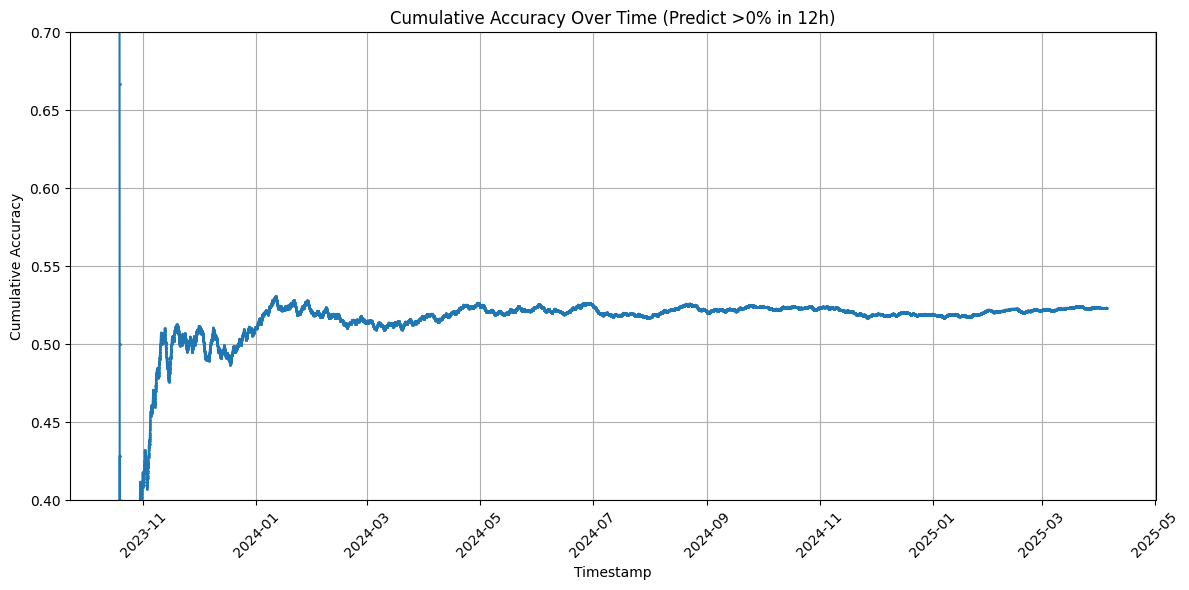

Script finished.


In [4]:
import pandas as pd
import numpy as np
import time
import os
import warnings
import traceback
from datetime import datetime
import matplotlib.pyplot as plt # Added for plotting

# Feature Engineering Imports
import pandas_ta as ta  # Technical indicators

# Modeling Imports
import xgboost as xgb # Use xgb directly
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore') # General suppression

# --- Configuration ---
CSV_FILE_PATH = r'C:\Users\mason\AVP\BTCUSDrec.csv' # Use raw string for Windows paths
SYMBOL_NAME = 'BTCUSD' # Define the symbol represented in the CSV

# FINAL VIF-Filtered Feature List (56 Features from VIF=7.3 run on comprehensive set)
SELECTED_FEATURE_NAMES = [
    'Volume USD',
    'bband_width_20h',
    'cci_20h',
    'close_pos_in_range',
    'cmf_20h',
    'day_0',
    'day_1',
    'day_2',
    'day_4',
    'day_5',
    'day_6',
    'hour_1',
    'hour_10',
    'hour_11',
    'hour_12',
    'hour_13',
    'hour_14',
    'hour_15',
    'hour_16',
    'hour_17',
    'hour_18',
    'hour_19',
    'hour_2',
    'hour_20',
    'hour_21',
    'hour_22',
    'hour_23',
    'hour_3',
    'hour_4',
    'hour_5',
    'hour_6',
    'hour_7',
    'hour_8',
    'hour_9',
    'lag_12h_price_return',
    'lag_12h_volume_return',
    'lag_168h_price_return',
    'lag_24h_price_return',
    'lag_24h_volume_return',
    'lag_3h_volume_return',
    'lag_48h_price_return',
    'lag_6h_price_return',
    'lag_6h_volume_return',
    'lag_72h_price_return',
    'macd_hist',
    'macd_signal',
    'obv_ma_24h',
    'rolling_kurt_24h',
    'rolling_skew_24h',
    'rolling_std_168h',
    'rolling_std_3h_sq',
    'rolling_std_6h',
    'std12_div_std72',
    'volume_btc_x_range',
    'volume_div_ma_24h',
    'volume_return_1h',
]

# Target Variable Configuration (Matching Successful Script B)
PREDICTION_HORIZON_HOURS = 12 # Predict direction over the next 12 hours
TARGET_COL_CALC = f'price_change_{PREDICTION_HORIZON_HOURS}h' # Name for intermediate calculation
TARGET_COL_BINARY = 'target'       # Final binary target column name

# Backtesting Parameters (Using Expanding Window like Script B)
INITIAL_TRAIN_SIZE_HOURS = 24 * 7 * 12  # ~3 months initial training (adjust as needed)
STEP_SIZE_HOURS = 24 * 7             # Retrain and predict every week (adjust frequency)

# XGBoost Model Parameters (Adjust based on tuning or keep reasonable defaults)
XGB_PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.05,             # Learning rate
    'max_depth': 4,            # Keep slightly deeper?
    'n_estimators': 150,       # Maybe increase slightly?
    'subsample': 0.8,
    'colsample_bytree': 0.8,   # Fraction of features per tree
    'min_child_weight': 1,     # Minimum sum of instance weight needed in a child
    'gamma': 0.1,              # Minimum loss reduction required to make a further partition
    'lambda': 1.5,             # L2 regularization
    'alpha': 0.1,              # L1 regularization
    'use_label_encoder': False,
    'random_state': 42,
    'n_jobs': -1,
    # 'tree_method': 'gpu_hist' # Uncomment if GPU is available and configured
}

# --- Helper Functions (Needed by Feature Generation) ---
def safe_divide(numerator, denominator):
    num = pd.Series(numerator) if not isinstance(numerator, pd.Series) else numerator
    den = pd.Series(denominator) if not isinstance(denominator, pd.Series) else denominator
    if den is not None and not den.empty:
        with np.errstate(divide='ignore', invalid='ignore'):
            result = num / den.replace(0, np.nan)
        return result
    return pd.Series(np.nan, index=num.index if isinstance(num, pd.Series) else None)

def safe_subtract(series1, series2):
    s1 = pd.Series(series1) if not isinstance(series1, pd.Series) else series1
    s2 = pd.Series(series2) if not isinstance(series2, pd.Series) else series2
    if s1 is not None and not s1.empty and s2 is not None and not s2.empty and pd.api.types.is_numeric_dtype(s1) and pd.api.types.is_numeric_dtype(s2):
         s1_aligned, s2_aligned = s1.align(s2, join='left')
         return s1_aligned - s2_aligned
    return pd.Series(np.nan, index=s1.index if s1 is not None else (s2.index if s2 is not None else None))

def safe_multiply(col1, col2):
    s1 = pd.Series(col1) if not isinstance(col1, pd.Series) else col1
    s2 = pd.Series(col2) if not isinstance(col2, pd.Series) else col2
    if s1 is not None and not s1.empty and s2 is not None and not s2.empty and pd.api.types.is_numeric_dtype(s1) and pd.api.types.is_numeric_dtype(s2):
         s1_aligned, s2_aligned = s1.align(s2, join='left')
         return s1_aligned * s2_aligned
    return pd.Series(np.nan, index=s1.index if s1 is not None else (s2.index if s2 is not None else None))

def safe_sq(col):
    s = pd.Series(col) if not isinstance(col, pd.Series) else col
    if s is not None and not s.empty and pd.api.types.is_numeric_dtype(s): return s**2
    return pd.Series(np.nan, index=s.index if s is not None else None)

def safe_log(col):
    s = pd.Series(col) if not isinstance(col, pd.Series) else col
    if s is not None and not s.empty and pd.api.types.is_numeric_dtype(s):
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.log(np.maximum(s, 1e-9))
        return result.replace([np.inf, -np.inf], np.nan)
    return pd.Series(np.nan, index=s.index if s is not None else None)

def safe_sqrt(col):
     s = pd.Series(col) if not isinstance(col, pd.Series) else col
     if s is not None and not s.empty and pd.api.types.is_numeric_dtype(s):
          return np.sqrt(s.clip(lower=0))
     return pd.Series(np.nan, index=s.index if s is not None else None)

# --- Feature Engineering Function (Comprehensive Version Used for VIF) ---
def calculate_advanced_features(df, symbol):
    """Calculate a comprehensive set of advanced features from OHLCV data."""
    # This function needs to generate AT LEAST all features in SELECTED_FEATURE_NAMES
    print("Starting comprehensive feature calculation...")
    start_time = time.time()
    if df is None or len(df) < 3: return pd.DataFrame()
    df = df.copy()
    df['symbol'] = symbol

    if 'timestamp' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['timestamp']): return pd.DataFrame()
    df = df.set_index('timestamp', drop=False) # Keep timestamp column

    # Standardize volume column names internally
    if 'Volume BTC' in df.columns: df['volume_btc'] = df['Volume BTC']
    elif 'volume_btc' not in df.columns: df['volume_btc'] = 0
    if 'Volume USD' in df.columns: df['volume_usd'] = df['Volume USD']
    elif 'volume_usd' not in df.columns: df['volume_usd'] = 0

    # Ensure OHLC are numeric
    required_ohlc = ['open', 'high', 'low', 'close']
    if not all(col in df.columns for col in required_ohlc): return pd.DataFrame()
    for col in required_ohlc: df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=required_ohlc)
    if df.empty: return pd.DataFrame()

    # --- Calculations (Mirroring the comprehensive function used for VIF) ---
    # Time-Based
    hour_of_day = df.index.hour; day_of_week = df.index.dayofweek
    for hour in range(24): df[f'hour_{hour}'] = (hour_of_day == hour).astype(int)
    for day in range(7): df[f'day_{day}'] = (day_of_week == day).astype(int)
    # Basic Price/Vol
    df['price_return_1h'] = df['close'].pct_change()
    df['oc_change_pct'] = safe_divide(df['close'] - df['open'], df['open'])
    df['price_range_pct'] = safe_divide(df['high'] - df['low'], df['low'])
    df['volume_return_1h'] = df['volume_btc'].pct_change()
    # MAs / Stds
    min_periods_base = 2
    for hours in [3, 6, 12, 24, 48, 72, 168]:
        if len(df) >= hours:
            df[f'ma_{hours}h'] = df['close'].rolling(window=hours, min_periods=min_periods_base).mean()
            df[f'rolling_std_{hours}h'] = df['close'].rolling(window=hours, min_periods=min_periods_base).std()
        else: df[f'ma_{hours}h'], df[f'rolling_std_{hours}h'] = np.nan, np.nan
    # Lags
    for hours in [3, 6, 12, 24, 48, 72, 168]: df[f'lag_{hours}h_price_return'] = df['close'].pct_change(periods=hours)
    for hours in [3, 6, 12, 24]: df[f'lag_{hours}h_volume_return'] = df['volume_btc'].pct_change(periods=hours)
    # Volatility
    log_hl = safe_log(safe_divide(df['high'], df['low']))**2
    log_co = safe_log(safe_divide(df['close'], df['open']))**2
    df['garman_klass_12h'] = safe_sqrt(0.5 * log_hl.rolling(12).sum() - (2*np.log(2)-1) * log_co.rolling(12).sum()) if len(df) >= 12 else np.nan
    df['parkinson_3h'] = safe_sqrt((1 / (4 * np.log(2))) * (safe_log(safe_divide(df['high'],df['low']))**2).rolling(3).sum()) if len(df) >= 3 else np.nan
    df['tr'] = np.maximum(df['high'] - df['low'], np.maximum(abs(df['high'] - df['close'].shift(1)), abs(df['low'] - df['close'].shift(1))))
    for hours in [14, 24, 48]: df[f'atr_{hours}h'] = df['tr'].rolling(hours).mean() if len(df) >= hours else np.nan
    # Momentum
    if len(df) >= 14: delta = df['close'].diff(); gain = (delta.where(delta > 0, 0)).rolling(14).mean(); loss = (-delta.where(delta < 0, 0)).rolling(14).mean(); rs = safe_divide(gain, loss); df['rsi_14h'] = (100 - (100 / (1 + rs))).replace([np.inf], 100).fillna(50)
    else: df['rsi_14h'] = 50.0
    if len(df) >= 26: ema_12 = df['close'].ewm(span=12, adjust=False).mean(); ema_26 = df['close'].ewm(span=26, adjust=False).mean(); df['macd'] = ema_12 - ema_26
    else: df['macd'] = np.nan
    if len(df) >= 35: df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean(); df['macd_hist'] = safe_subtract(df['macd'], df['macd_signal'])
    else: df['macd_signal'], df['macd_hist'] = np.nan, np.nan
    # Volume-Based
    for hours in [12, 24, 72, 168]: df[f'volume_ma_{hours}h'] = df['volume_btc'].rolling(hours, min_periods=min_periods_base).mean() if len(df) >= hours else np.nan
    df['volume_div_ma_24h'] = safe_divide(df['volume_btc'], df['volume_ma_24h'])
    obv = (np.sign(df['close'].diff()) * df['volume_btc']).fillna(0).cumsum(); df['obv'] = obv
    df['obv_ma_24h'] = df['obv'].rolling(24, min_periods=min_periods_base).mean() if len(df) >= 24 else np.nan
    # Ratios
    df['close_div_ma_24h'] = safe_divide(df['close'], df['ma_24h'])
    df['close_div_ma_48h'] = safe_divide(df['close'], df['ma_48h'])
    df['close_div_ma_168h'] = safe_divide(df['close'], df['ma_168h'])
    df['ma12_div_ma48'] = safe_divide(df['ma_12h'], df['ma_48h'])
    df['ma24_div_ma168'] = safe_divide(df['ma_24h'], df['ma_168h'])
    df['std12_div_std72'] = safe_divide(df['rolling_std_12h'], df['rolling_std_72h'])
    df['atr_14_div_atr_48'] = safe_divide(df['atr_14h'], df['atr_48h'])
    # Normalized Price Position
    if len(df) >= 14: low_14 = df['low'].rolling(14).min(); high_14 = df['high'].rolling(14).max(); df['stoch_k'] = safe_divide(100 * (df['close'] - low_14), (high_14 - low_14)).replace(np.inf, 50).fillna(50)
    else: df['stoch_k'] = 50.0
    if len(df) >= 16: df['stoch_d'] = df['stoch_k'].rolling(3).mean()
    else: df['stoch_d'] = np.nan
    df['z_score_24h'] = safe_divide(df['close'] - df['ma_24h'], df['rolling_std_24h'])
    # Higher-Order Stats
    if len(df) >= 24 and 'price_return_1h' in df.columns: df['rolling_skew_24h'] = df['price_return_1h'].rolling(24).skew(); df['rolling_kurt_24h'] = df['price_return_1h'].rolling(24).kurt()
    else: df['rolling_skew_24h'], df['rolling_kurt_24h'] = np.nan, np.nan
    # Interaction & Non-linear
    df['volume_btc_x_range'] = safe_multiply(df['volume_btc'], df['price_range_pct'])
    df['rolling_std_3h_sq'] = safe_sq(df['rolling_std_3h'])
    df['price_return_1h_sq'] = safe_sq(df['price_return_1h'])
    df['rolling_std_12h_sqrt'] = safe_sqrt(df['rolling_std_12h'].abs())
    # pandas_ta
    ta_df = df.rename(columns={'volume_btc': 'volume'}, errors='ignore')
    if all(c in ta_df.columns for c in ['high', 'low', 'close']):
        try: adx = ta_df.ta.adx(14); df['adx_14h']=adx[f'ADX_14']; df['plus_di_14h']=adx[f'DMP_14']; df['minus_di_14h']=adx[f'DMN_14']
        except: df['adx_14h'], df['plus_di_14h'], df['minus_di_14h'] = np.nan, np.nan, np.nan
        if 'volume' in ta_df.columns:
            try: df['ad_line'] = ta_df.ta.ad()
            except: df['ad_line'] = np.nan
            try: df['cmf_20h'] = ta_df.ta.cmf(20)
            except: df['cmf_20h'] = np.nan
        else: df['ad_line'], df['cmf_20h'] = np.nan, np.nan
        try: df['cci_20h'] = ta_df.ta.cci(20)
        except: df['cci_20h'] = np.nan
        try: bbands = ta_df.ta.bbands(20, 2); df['bband_width_20h']=bbands[f'BBB_20_2.0']; df['bband_pctb_20h']=bbands[f'BBP_20_2.0']
        except: df['bband_width_20h'], df['bband_pctb_20h'] = np.nan, np.nan
    else: df['adx_14h'],df['plus_di_14h'],df['minus_di_14h'],df['ad_line'],df['cmf_20h'],df['cci_20h'],df['bband_width_20h'],df['bband_pctb_20h'] = [np.nan]*8
    # Position in Range
    range_hl = df['high'] - df['low']; df['close_pos_in_range'] = safe_divide(df['close'] - df['low'], range_hl).fillna(0.5).replace([np.inf, -np.inf], 0.5)
    # Additional
    df['log_return_1h'] = safe_log(safe_divide(df['close'], df['close'].shift(1)))
    if 'volume_btc' in df.columns and len(df) >= 24: num = (df['close'] * df['volume_btc']).rolling(24).sum(); den = df['volume_btc'].rolling(24).sum(); df['vwap_24h'] = safe_divide(num, den).fillna(method='ffill')
    else: df['vwap_24h'] = np.nan
    if 'close' in ta_df.columns:
        try: stochrsi=ta_df.ta.stochrsi(14); k=next((c for c in stochrsi if 'k' in c),None); d=next((c for c in stochrsi if 'd' in c),None); df['stoch_rsi_k']=stochrsi[k]; df['stoch_rsi_d']=stochrsi[d]
        except: df['stoch_rsi_k'], df['stoch_rsi_d'] = np.nan, np.nan
    else: df['stoch_rsi_k'], df['stoch_rsi_d'] = np.nan, np.nan

    # --- Final Cleanup ---
    df = df.reset_index(drop=True) # Drop time index before returning
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.drop(columns=['tr'], errors='ignore') # Drop intermediate TR

    # --- Select ONLY the final VIF-filtered features + essentials ---
    # This ensures we only pass the desired columns to the modeling part
    essential_cols = ['timestamp', 'symbol', 'open', 'high', 'low', 'close']
    # Use the global SELECTED_FEATURE_NAMES list defined in config
    final_cols_to_keep = essential_cols + SELECTED_FEATURE_NAMES
    # Check which columns actually exist in the dataframe after calculation
    final_cols_present = [col for col in final_cols_to_keep if col in df.columns]
    missing_cols = set(final_cols_to_keep) - set(final_cols_present)
    if missing_cols:
        print(f"Warning: The following columns requested for the model are missing after feature generation: {missing_cols}")

    end_time = time.time()
    print(f"Feature calculation finished. Returning {len(df)} rows. Took {end_time - start_time:.2f}s")
    return df[final_cols_present] # Return only existing requested columns

# --- Main Execution Block ---
if __name__ == "__main__":

    print("--- 1. Load Data & Preprocessing ---")
    try:
        print(f"Loading data from: {CSV_FILE_PATH}")
        col_names = ['unix', 'date', 'symbol_csv', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
        df_raw = pd.read_csv(CSV_FILE_PATH, header=0, names=col_names)
        print(f"Raw data loaded. Shape: {df_raw.shape}")

        # Create timestamp, drop originals
        if 'date' in df_raw.columns: df_raw['timestamp'] = pd.to_datetime(df_raw['date'])
        elif 'unix' in df_raw.columns: df_raw['timestamp'] = pd.to_datetime(df_raw['unix'], unit='ms')
        else: exit("Error: Cannot find 'date' or 'unix' column.")
        cols_to_drop_init = ['unix', 'date', 'symbol_csv']
        df_raw = df_raw.drop(columns=cols_to_drop_init, errors='ignore')
        df_raw = df_raw.sort_values('timestamp').reset_index(drop=True)

        # Select last N rows
        N_ROWS = 15000
        if len(df_raw) >= N_ROWS:
             df = df_raw.iloc[-N_ROWS:].reset_index(drop=True)
             print(f"Selected the last {len(df)} rows for backtesting.")
        else:
             df = df_raw.copy()
             print(f"Using all {len(df)} available rows (less than {N_ROWS}).")

        if df.empty: exit("DataFrame empty after initial processing. Exiting.")
        print(f"Data prepared for feature engineering. Shape: {df.shape}")

    except Exception as e: print(f"Error loading data: {e}"); traceback.print_exc(); exit()


    print("\n--- 2. Feature Engineering ---")
    feature_calc_start = time.time()
    # Call the comprehensive feature function
    df_features = calculate_advanced_features(df, symbol=SYMBOL_NAME)
    feature_calc_end = time.time()

    if df_features.empty: exit("Feature calculation failed. Exiting.")
    print(f"Feature calculation completed in {feature_calc_end - feature_calc_start:.2f} seconds.")

    # Verify the selected features are present AFTER generation
    generated_cols = df_features.columns.tolist()
    CURRENT_FEATURE_COLS = [f for f in SELECTED_FEATURE_NAMES if f in generated_cols]
    missing_selected = set(SELECTED_FEATURE_NAMES) - set(CURRENT_FEATURE_COLS)
    if missing_selected:
        print(f"WARNING: The following {len(missing_selected)} selected features are MISSING after generation: {missing_selected}")
    if not CURRENT_FEATURE_COLS: exit("ERROR: None of the selected features were found after generation.")
    print(f"Proceeding with {len(CURRENT_FEATURE_COLS)} features found out of {len(SELECTED_FEATURE_NAMES)} selected.")


    print("\n--- 3. Define Target Variable ---")
    target_shift = -PREDICTION_HORIZON_HOURS
    print(f"Defining target variable: Price change > 0 over next {PREDICTION_HORIZON_HOURS} hours...")
    # Use df_features which contains the features AND the base 'close' column
    df_features[TARGET_COL_CALC] = df_features['close'].shift(target_shift).sub(df_features['close']).div(df_features['close'].replace(0, np.nan)).mul(100)
    df_features[TARGET_COL_BINARY] = (df_features[TARGET_COL_CALC] > 0).astype(int)

    # --- 4. Prepare Data for Modeling ---
    print("Preparing data for modeling...")

    # Define columns to keep: timestamp + CURRENT_FEATURE_COLS + binary target
    final_model_cols = ['timestamp'] + CURRENT_FEATURE_COLS + [TARGET_COL_BINARY]
    # Select only these columns from the potentially larger df_features
    df_model_ready = df_features[final_model_cols].copy()

    # Handle NaNs (from lookbacks and target shift)
    initial_rows = len(df_model_ready)
    df_model_ready = df_model_ready.dropna() # Drop rows with ANY NaN
    final_rows = len(df_model_ready)
    print(f"Handled NaNs. Dropped {initial_rows - final_rows} rows.")

    # Final check for infinites
    numeric_cols = df_model_ready.select_dtypes(include=np.number).columns.tolist()
    numeric_cols_no_target = [col for col in numeric_cols if col != TARGET_COL_BINARY]
    inf_count = np.isinf(df_model_ready[numeric_cols_no_target].values).sum()
    if inf_count > 0:
        print(f"Warning: Replacing {inf_count} infinite values with NaN AFTER initial dropna.")
        df_model_ready = df_model_ready.replace([np.inf, -np.inf], np.nan)
        rows_before_inf_drop = len(df_model_ready)
        df_model_ready = df_model_ready.dropna()
        print(f"Dropped {rows_before_inf_drop - len(df_model_ready)} additional rows.")
        final_rows = len(df_model_ready) # Update final_rows count

    # Convert hours to rows for window sizes
    initial_train_size_rows = INITIAL_TRAIN_SIZE_HOURS
    step_size_rows = STEP_SIZE_HOURS

    if final_rows < initial_train_size_rows + step_size_rows:
         print(f"Error: Not enough data ({final_rows} rows) remaining after NaN handling for initial training size ({initial_train_size_rows}) and step ({step_size_rows}).")
         exit()

    # Define X, y, timestamps from the final cleaned data
    print("Defining Features (X) and Binary Target (y)...")
    X = df_model_ready[CURRENT_FEATURE_COLS] # Use the features available
    y_binary = df_model_ready[TARGET_COL_BINARY]
    timestamps = df_model_ready['timestamp']

    print(f"Final feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y_binary.shape}")
    print(f"Number of feature columns used for modeling: {len(X.columns)}")


    # --- 5. Rolling Backtesting with Single XGBoost Model ---
    print("\n--- Starting Rolling Backtest (Single XGBoost) ---")
    print(f"Initial Train Size: {initial_train_size_rows} rows ({INITIAL_TRAIN_SIZE_HOURS}h)")
    print(f"Step Size: {step_size_rows} rows ({STEP_SIZE_HOURS}h)")

    # Store results
    all_predictions = []
    all_actual = []
    all_probabilities = []
    backtest_timestamps = []

    # Loop through the data using an expanding window
    num_predictions_total = 0
    start_loop_time = time.time()

    for i in range(initial_train_size_rows, len(X), step_size_rows):
        train_idx_end = i
        test_idx_start = i
        test_idx_end = min(i + step_size_rows, len(X))

        if test_idx_start >= test_idx_end: break

        X_train_roll = X.iloc[:train_idx_end]
        y_train_roll = y_binary.iloc[:train_idx_end]
        X_test_roll = X.iloc[test_idx_start:test_idx_end]
        y_test_roll_actual = y_binary.iloc[test_idx_start:test_idx_end]
        current_timestamps = timestamps.iloc[test_idx_start:test_idx_end]

        if len(X_test_roll) == 0: continue

        iter_num = (i - initial_train_size_rows) // step_size_rows + 1
        print(f"\n--- Iter {iter_num} ---")
        print(f"  Train Range: [0:{train_idx_end-1}], Test Range: [{test_idx_start}:{test_idx_end-1}]")

        # Calculate scale_pos_weight
        neg_count = (y_train_roll == 0).sum(); pos_count = (y_train_roll == 1).sum()
        scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
        print(f"  scale_pos_weight: {scale_pos_weight:.2f}")

        # Initialize and Train XGBoost Model
        model_roll = xgb.XGBClassifier(**XGB_PARAMS, scale_pos_weight=scale_pos_weight)
        model_roll.fit(X_train_roll, y_train_roll, verbose=False)

        # Make predictions
        pred_roll = model_roll.predict(X_test_roll)
        prob_roll = model_roll.predict_proba(X_test_roll)[:, 1]

        # Store results
        all_predictions.extend(pred_roll.tolist())
        all_actual.extend(y_test_roll_actual.tolist())
        all_probabilities.extend(prob_roll.tolist())
        backtest_timestamps.extend(current_timestamps.tolist())

        num_predictions_total += len(pred_roll)
        print(f"  Iteration {iter_num} complete. Processed {num_predictions_total} total predictions.")

    end_loop_time = time.time()
    loop_duration_minutes = (end_loop_time - start_loop_time) / 60
    print(f"\nBacktesting finished in {end_loop_time - start_loop_time:.2f} seconds ({loop_duration_minutes:.2f} minutes). Made {num_predictions_total} predictions.")

    # --- 6. Evaluate Backtesting Results ---
    if num_predictions_total > 0:
        if not (len(all_actual) == len(all_predictions) == len(all_probabilities) == len(backtest_timestamps)):
             print("Error: Result list lengths do not match!")
        else:
            final_accuracy = accuracy_score(all_actual, all_predictions)
            final_precision = precision_score(all_actual, all_predictions, zero_division=0)
            final_recall = recall_score(all_actual, all_predictions, zero_division=0)
            final_f1 = f1_score(all_actual, all_predictions, zero_division=0)

            print("\n--- Backtesting Performance Metrics ---")
            print(f"Target: Price Change > 0% over {PREDICTION_HORIZON_HOURS} hours")
            print(f"Training Window: Expanding (Starts {INITIAL_TRAIN_SIZE_HOURS}h)")
            print(f"Step Size: {STEP_SIZE_HOURS}h")
            print(f"Number of Features Used: {len(SELECTED_FEATURE_NAMES)}") # Use the final list count
            print("-" * 20)
            print(f"Overall Accuracy:  {final_accuracy:.4f}")
            print(f"Overall Precision: {final_precision:.4f}")
            print(f"Overall Recall:    {final_recall:.4f}")
            print(f"Overall F1 Score:  {final_f1:.4f}")

            results_df = pd.DataFrame({ 'timestamp': backtest_timestamps, 'actual': all_actual, 'predicted': all_predictions, 'probability': all_probabilities })
            print("\nSample of Results:"); print(results_df.head())

            # --- Optional: Plot Cumulative Accuracy ---
            cumulative_correct = np.cumsum(np.array(all_actual) == np.array(all_predictions))
            cumulative_count = np.arange(1, len(all_actual) + 1)
            cumulative_accuracy_plot = cumulative_correct / cumulative_count
            print("\nPlotting cumulative accuracy...")
            try:
                plt.figure(figsize=(12, 6)); plt.plot(backtest_timestamps, cumulative_accuracy_plot, marker='.', linestyle='-', markersize=2)
                plt.title(f'Cumulative Accuracy Over Time (Predict >0% in {PREDICTION_HORIZON_HOURS}h)'); plt.xlabel('Timestamp'); plt.ylabel('Cumulative Accuracy')
                plt.ylim(0.4, 0.7); plt.grid(True); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
            except Exception as e_plot: print(f"Could not generate plot: {e_plot}")
    else: print("No predictions were made.")

print("Script finished.")